<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°08

**Objetivo**: Aplicar técnicas de **machine learning no supervisado** para explorar, procesar y analizar conjuntos de datos con variables numéricas y categóricas.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


## Clustering


<img src="https://www.svgrepo.com/show/253022/car.svg" width = "300" align="center"/>



El conjunto de datos **`vehiculos_procesado_con_grupos.csv`** recopila información sobre diversas características relevantes de distintos vehículos. El propósito de este ejercicio es **clasificar los vehículos en diferentes categorías**, utilizando como base las variables descritas en la tabla de atributos.

El análisis presenta un desafío adicional debido a la **naturaleza mixta de los datos**: se incluyen tanto variables **numéricas** (ej. dimensiones, consumo, emisiones) como **categóricas** (ej. tipo de tracción, tipo de combustible), lo que requiere aplicar técnicas de preprocesamiento adecuadas antes de entrenar los modelos.

Como primer paso, procederemos a **cargar y explorar el conjunto de datos**, con el fin de familiarizarnos con su estructura y las características que servirán como base para la posterior clasificación.




**Descripción de los Datos:**

| **Nombre de la Columna**   | **Descripción**                                                                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **year**                   | El año en que el vehículo fue fabricado.                                                                                                          |
| **desplazamiento**          | La capacidad volumétrica del motor en litros. Indica la cantidad de aire y combustible que puede desplazar el motor durante una revolución.       |
| **cilindros**               | El número de cilindros que tiene el motor. Los cilindros son las cámaras donde ocurre la combustión interna en los motores de los vehículos.       |
| **co2**                     | Emisiones de dióxido de carbono del vehículo, medido en gramos por kilómetro. Es una medida de las emisiones de gases de efecto invernadero.       |
| **clase_tipo**              | La clase o tipo de vehículo, como vehículos especiales, deportivos, etc.                                                                         |
| **traccion_tipo**           | Tipo de tracción del vehículo, ya sea tracción en dos ruedas, en cuatro ruedas o en todas las ruedas.                                             |
| **transmision_tipo**        | Tipo de transmisión del vehículo, como automática, manual, entre otros.                                                                          |
| **combustible_tipo**        | Tipo de combustible que utiliza el vehículo, como gasolina, diésel, eléctrico, híbrido, etc.                                                     |
| **tamano_motor_tipo**       | Clasificación del tamaño del motor (por ejemplo, pequeño, mediano o grande), que generalmente se basa en la capacidad de desplazamiento.           |
| **consumo_tipo**            | Clasificación del nivel de consumo de combustible del vehículo, indicando si es alto, bajo, o muy alto.                                           |
| **co2_tipo**                | Clasificación de las emisiones de CO2 del vehículo, indicando si es alto, bajo, o muy alto.                                                       |
| **consumo_litros_milla**    | El consumo de combustible del vehículo, medido en litros por milla. Indica la eficiencia del vehículo en términos de consumo de combustible.        |



In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans


%matplotlib inline

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [51]:
# cargar datos
df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/vehiculos_procesado_con_grupos.csv", sep=",")\
       .drop(
            ["fabricante",
             "modelo",
             "transmision",
             "traccion",
             "clase",
             "combustible",
             "consumo"],

          axis=1)

df.head()

,year,desplazamiento,cilindros,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,1984,2.5,4.0,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,1984,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,1985,2.5,4.0,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,1985,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,1987,3.8,6.0,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


En este caso, no solo se tienen datos numéricos, sino que también categóricos. Además, tenemos problemas de datos **vacíos (Nan)**. Así que para resolver este problema, seguiremos varios pasos:

### 1.- Normalizar datos

- Cree un conjunto de datos con las variables numéricas, además, para cada dato vacía, rellene con el promedio asociado a esa columna. Finalmente, normalize los datos mediante el procesamiento **MinMaxScaler** de **sklearn**.
- Cree un conjunto de datos con las variables categóricas , además, transforme de variables categoricas a numericas ocupando el comando **get_dummies** de pandas ([referencia](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Explique a grande rasgo como se realiza la codificación de variables numéricas a categóricas.

- Junte ambos dataset en uno, llamado **df_procesado**.

In [52]:
# Separar variables numéricas y categóricas
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()

# Crear el dataset con las variables numéricas
df_numerical = df[numerical_cols].copy()

# Rellenar valores vacíos con el promedio de cada columna
df_numerical = df_numerical.fillna(df_numerical.mean())

scaler = MinMaxScaler()
df_numerical_scaled = scaler.fit_transform(df_numerical)

# Convertimos el resultado nuevamente en DataFrame
df_numerical_scaled = pd.DataFrame(df_numerical_scaled, columns=numerical_cols)

# Crear el dataset con las variables categóricas
df_categorical = df[categorical_cols].copy()

# Codificar variables categóricas a numéricas
df_categorical_encoded = pd.get_dummies(df_categorical)

df_procesado = pd.concat([df_numerical_scaled, df_categorical_encoded], axis=1)

display(df_procesado.head())

,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0.000000,0.243590,0.142857,0.398014,0.331027,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1,0.000000,0.461538,0.285714,0.527672,0.475113,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0.029412,0.243590,0.142857,0.424351,0.360294,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
3,0.029412,0.461538,0.285714,0.527672,0.475113,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,0.088235,0.410256,0.285714,0.424351,0.360294,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,False


El proceso de codificación de variables categóricas a numéricas consiste en transformar datos de tipo texto en valores numéricos para que los algoritmos puedan procesarlos.
Con get_dummies(), cada categoría se convierte en una columna nueva con valores 0 o 1, según si el registro pertenece o no a esa categoría.



### 2.- Realizar ajuste mediante kmeans

Una vez depurado el conjunto de datos, es momento de aplicar el algoritmo de **kmeans**.

1. Ajuste el modelo de **kmeans** sobre el conjunto de datos, con un total de **8 clusters**.
2. Asociar a cada individuo el correspondiente cluster y calcular valor de los centroides de cada cluster.
3. Realizar un resumen de las principales cualidades de cada cluster. Para  esto debe calcular (para cluster) las siguientes medidas de resumen:
    * Valor promedio de las variables numérica
    * Moda para las variables numericas

In [53]:
# Definir y ajustar el modelo KMeans con 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(df_procesado)

# Asignar a cada observación el número de cluster correspondiente
df_procesado['cluster'] = kmeans.labels_

# Centroides del modelo
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=df_procesado.columns[:-1])

# Separar nombres de variables
num_cols = df_numerical_scaled.columns
cat_cols = df_categorical_encoded.columns

# Promedio de las variables numéricas por cluster
promedios_cluster = df_procesado.groupby('cluster')[num_cols].mean()

# Moda de las variables categóricas por cluster
modas_cluster = df_procesado.groupby('cluster')[cat_cols].agg(lambda x: x.mode().iloc[0])

display(promedios_cluster)
display(modas_cluster)

,year,desplazamiento,cilindros,co2,consumo_litros_milla
cluster,,,,,
0,0.375242,0.314568,0.244567,0.354655,0.281424
1,0.695630,0.178857,0.150271,0.240158,0.156818
2,0.440116,0.361599,0.287553,0.354467,0.281434
3,0.523869,0.250495,0.195088,0.304375,0.226729
4,0.412004,0.576146,0.420130,0.506937,0.449663
5,0.438752,0.159481,0.141102,0.242174,0.156452
6,0.476203,0.446766,0.325461,0.410605,0.344917
7,0.723894,0.352271,0.282857,0.352779,0.279733


,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,clase_tipo_Deportivos,clase_tipo_Furgoneta,clase_tipo_Vehículos Especiales,traccion_tipo_cuatro,traccion_tipo_dos,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
cluster,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
1,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,True,...,False,True,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
5,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
6,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,False,True,False,False,False,False
7,False,False,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,True,False,False


### 3.- Elegir Número de cluster

Estime mediante la **regla del codo**, el número de cluster apropiados para el caso.
Para efectos prácticos, eliga la siguiente secuencia como número de clusters a comparar:

$$[5, 10, 20, 30, 50, 75, 100, 200, 300]$$

Una vez realizado el gráfico, saque sus propias conclusiones del caso.

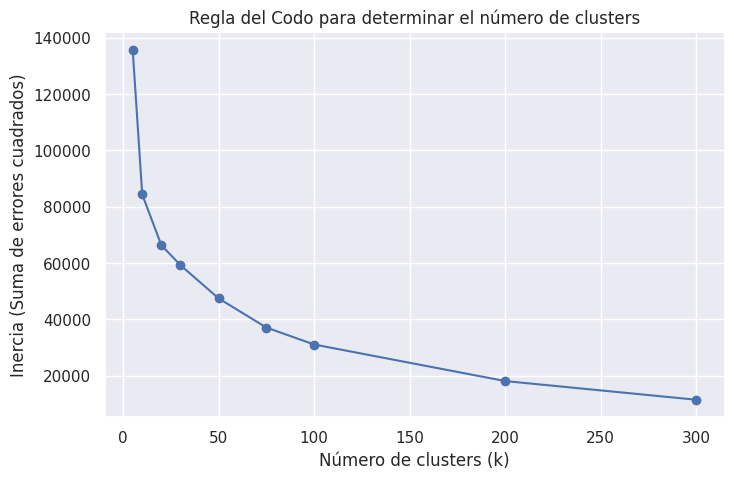

In [54]:
# Secuencia de número de clusters a comparar
k_values = [5, 10, 20, 30, 50, 75, 100, 200, 300]

# Lista para guardar los valores de inercia
inertia_values = []

# Calcular el modelo para cada número de clusters
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_procesado)
    inertia_values.append(kmeans.inertia_)

# Graficar la regla del codo
plt.figure(figsize=(8,5))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Regla del Codo para determinar el número de clusters')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Suma de errores cuadrados)')
plt.grid(True)
plt.show()

Al observar el gráfico resultante, se pueden obtener conclusiones sobre el número apropiado de clusters. La regla del codo sugiere elegir el número de clusters donde la reducción en la inercia se estabiliza significativamente. En otras palabras, se busca el punto en el gráfico donde la curva de inercia comienza a aplanarse o forma un codo.

El grafico comienza a estabilizarse  alrededor del 5to punto, es decir, con 50 clusters

## Reducción de Dimensionalidad

<img src="https://1000logos.net/wp-content/uploads/2020/11/Wine-Logo-old.png" width = "300" align="center"/>


Para este ejercicio utilizaremos el **Wine Dataset**, un conjunto de datos clásico disponible en la librería **scikit-learn** y en el repositorio de la **UCI Machine Learning**.
Este dataset contiene información de **178 muestras de vino** provenientes de la región italiana de *Piamonte*. Cada vino pertenece a una de **tres variedades de uva** (*clases*), que actúan como etiquetas para el análisis supervisado, pero aquí se usarán solo como referencia en la visualización.

Cada muestra está descrita por **13 variables químicas** obtenidas de un análisis de laboratorio, entre ellas:

* **Alcohol**: porcentaje de alcohol en el vino.
* **Malic acid**: concentración de ácido málico.
* **Ash**: contenido de ceniza.
* **Alcalinity of ash**: alcalinidad de la ceniza.
* **Magnesium**: cantidad de magnesio (mg/L).
* **Total phenols**: concentración total de fenoles.
* **Flavanoids**: tipo de fenoles con propiedades antioxidantes.
* **Nonflavanoid phenols**: fenoles que no son flavonoides.
* **Proanthocyanins**: compuestos relacionados con el color y el sabor.
* **Color intensity**: intensidad del color del vino.
* **Hue**: matiz del color.
* **OD280/OD315 of diluted wines**: relación de absorbancia que mide la calidad del vino.
* **Proline**: concentración de prolina (un aminoácido).

Estas características permiten representar cada vino como un punto en un espacio de **13 dimensiones**.

El objetivo del análisis con este dataset es **reducir la dimensionalidad** para visualizar y explorar patrones en los datos. Para ello aplicaremos:

* **PCA (Principal Component Analysis):** identificar las combinaciones lineales de variables que explican la mayor varianza en el conjunto.
* **t-SNE (t-distributed Stochastic Neighbor Embedding):** mapear las muestras a 2D o 3D, preservando relaciones de vecindad y estructuras no lineales.

La comparación entre ambas técnicas permitirá observar cómo las tres clases de vinos se diferencian en el espacio reducido y discutir la utilidad de la reducción de dimensionalidad en datos con mayor número de variables que en el caso del dataset *Wine*.



In [55]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [56]:
# cargar dataset
dataset = load_wine()

# nombres de las variables
features = dataset.feature_names
target = 'wine_class'

# construir DataFrame
wine = pd.DataFrame(dataset.data, columns=features)
wine[target] = dataset.target

# ver primeras filas
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0




### 1. **Análisis detallado con PCA**

* Calcular la **varianza explicada** por cada componente principal y representar el gráfico de varianza acumulada, identificando cuántos componentes son necesarios para capturar al menos el **90–95% de la información**.
* Construir tablas y gráficos que muestren cómo las observaciones (vinos) se proyectan en las primeras componentes principales.
* Analizar los **loadings** (coeficientes de cada variable en los componentes) e interpretar qué características químicas del vino (alcohol, fenoles, color, etc.) tienen mayor influencia en las nuevas dimensiones.
* Visualizar los datos reducidos a 2D o 3D e interpretar si las **tres variedades de vino** se separan de forma clara en el espacio proyectado.



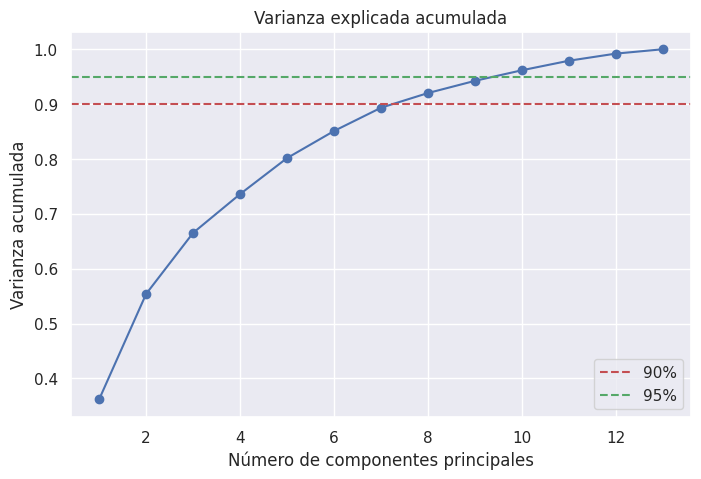

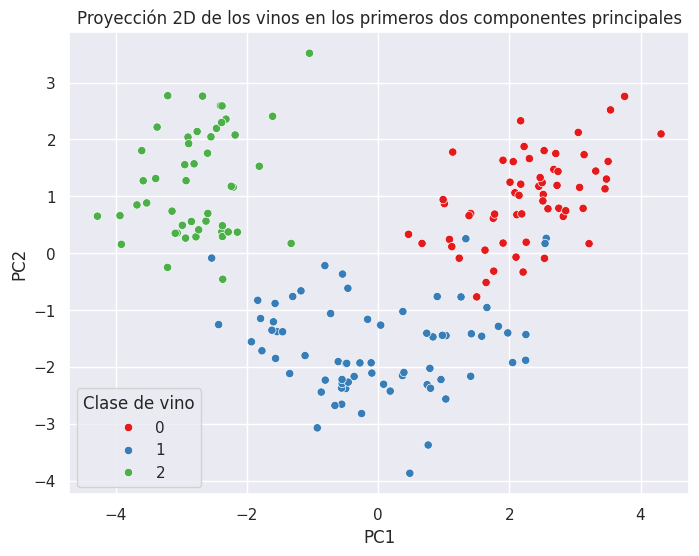

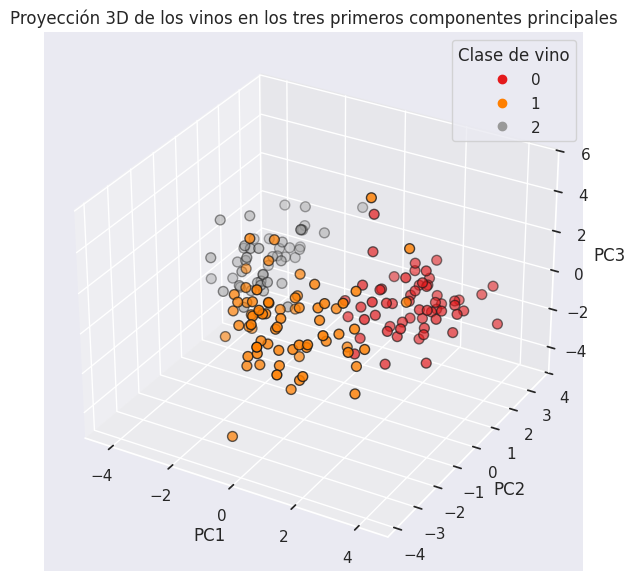


Loadings de las variables en los componentes principales:


,PC1,PC2,PC3
alcohol,0.144329,0.483652,-0.207383
malic_acid,-0.245188,0.224931,0.089013
ash,-0.002051,0.316069,0.626224
alcalinity_of_ash,-0.239320,-0.010591,0.612080
magnesium,0.141992,0.299634,0.130757
total_phenols,0.394661,0.065040,0.146179
flavanoids,0.422934,-0.003360,0.150682
nonflavanoid_phenols,-0.298533,0.028779,0.170368
proanthocyanins,0.313429,0.039302,0.149454
color_intensity,-0.088617,0.529996,-0.137306


In [62]:
from sklearn.preprocessing import StandardScaler

X = wine[features]
y = wine[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
var_exp = pca.explained_variance_ratio_
var_exp_acum = var_exp.cumsum()

# Gráfico de varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp_acum)+1), var_exp_acum, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.title('Varianza explicada acumulada')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada')
plt.legend()
plt.grid(True)
plt.show()

# PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# DataFrame con componentes principales
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df[target] = y

# ----------- 1. Gráfico 2D (PC1 vs PC2) -----------
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=target, palette='Set1')
plt.title('Proyección 2D de los vinos en los primeros dos componentes principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Clase de vino')
plt.grid(True)
plt.show()

# ----------- 2. Gráfico 3D (PC1 vs PC2 vs PC3) -----------
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
                     c=pca_df[target], cmap='Set1', edgecolor='k', s=50)
ax.set_title('Proyección 3D de los vinos en los tres primeros componentes principales')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(*scatter.legend_elements(), title='Clase de vino')
plt.show()

# ----------- 3. Loadings (coeficientes de variables en PCs) -----------
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC1', 'PC2', 'PC3'],
                        index=features)

# Mostrar los loadings
print("\nLoadings de las variables en los componentes principales:")
display(loadings)


Para alcanzar el 90% de la varianza explicada, se necesitan 8 componentes principales.

Para alcanzar el 95% de la varianza explicada, se necesitan 10 componentes principales.

PC1 representa principalmente asociada a su sabor, envejecimiento y tipo de uva.( phenols, flavonoids, proanthocyanins)
PC2 puede estar reflejando propiedades relacionadas con el color y la acidez (Color_intensity, Ash, malic_acid y proline).
PC3 está relacionada con el contenido mineral del vino (ash, alcalinity_of_ash y magnesium)

Podemos ver que las variables en los planos 2D y 3D si estan separadas entre si



### 2. **Análisis detallado con t-SNE**

* Aplicar **t-SNE** para reducir los datos a 2 dimensiones, probando diferentes configuraciones de hiperparámetros como *perplexity* y *learning rate*.
* Comparar las distintas visualizaciones obtenidas y discutir cómo los hiperparámetros afectan la estructura de los clústeres.
* Analizar si las **tres clases de vinos** forman agrupaciones definidas y si t-SNE logra capturar relaciones no lineales que PCA no refleja.



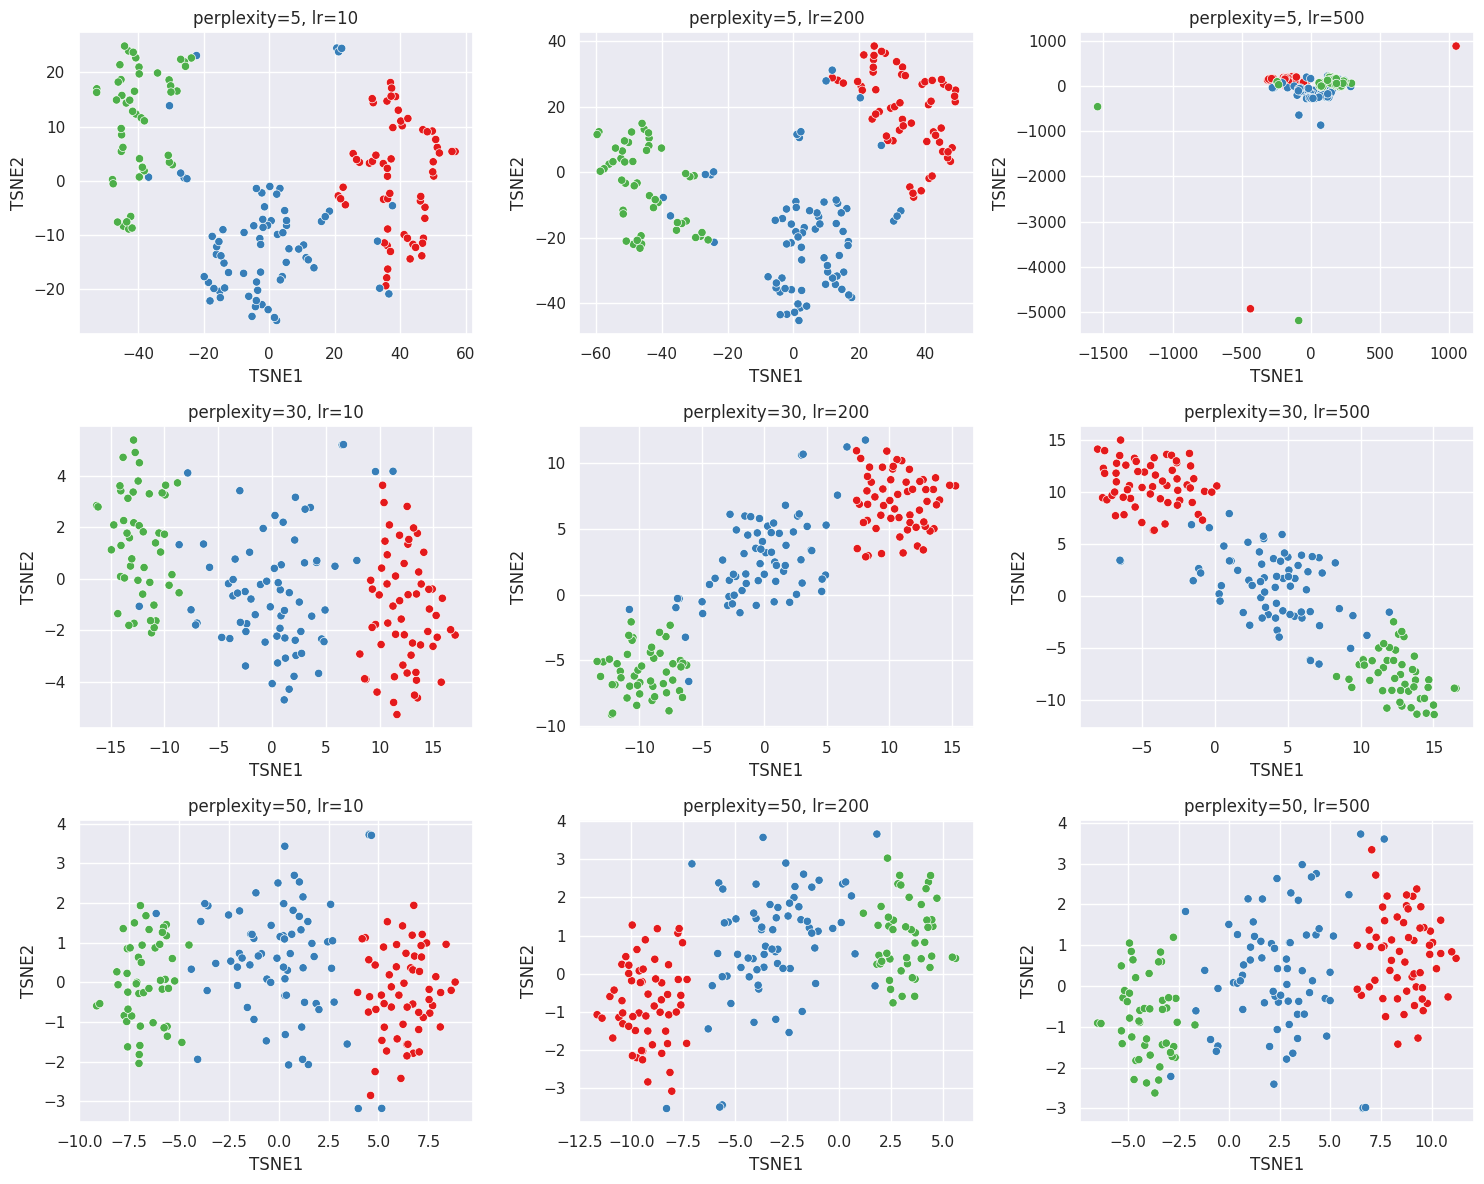

In [58]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

perplexities = [5, 30, 50]
learning_rates = [10, 200, 500]

fig, axes = plt.subplots(len(perplexities), len(learning_rates), figsize=(15,12))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(n_components=2, perplexity=perp, learning_rate=lr, random_state=42)
        X_tsne = tsne.fit_transform(X_scaled)

        df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1','TSNE2'])
        df_tsne['wine_class'] = y

        ax = axes[i, j]
        sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='wine_class', palette='Set1', ax=ax, legend=False)
        ax.set_title(f'perplexity={perp}, lr={lr}')
plt.tight_layout()
plt.show()

Perplexity baja (5): se enfoca en relaciones locales tiene buena separación, pero puede exagerar.

Perplexity alta (50): considera vecinos más lejanos, puede mejorar agrupaciones globales.

LR
Muy bajo (10): puede converger lento o caer en mínimos locales.

Moderado (200): óptimo en la mayoría de los casos.

Muy alto (500): puede provocar explosiones numéricas y distorsiones.

t-SNE supera a PCA ya que PCA no capta relaciones no lineales y es posible notar que en este caso t-SNE si considera logra capturar relaciones no lineales



### 3. **Comparación entre PCA y t-SNE**

* Contrastar las visualizaciones y discutir las **ventajas y limitaciones** de cada técnica:

  * PCA como método **lineal** para interpretar varianza y relaciones globales.
  * t-SNE como método **no lineal** que preserva relaciones locales y vecindades.
* Evaluar en qué escenarios prácticos sería más recomendable usar PCA (interpretabilidad, reducción previa para modelos) o t-SNE (exploración y visualización de clústeres).
* Reflexionar sobre la **importancia de la reducción de dimensionalidad** en datasets de alta dimensión como Wine, destacando su utilidad para:

  * Visualizar patrones ocultos en los datos.
  * Reducir complejidad y ruido antes de aplicar algoritmos de aprendizaje automático.
  * Facilitar la interpretación y comunicación de resultados.



PCA tiene como principales ventajas su rapidez, su determinismo y su interpretabilidad. Es ideal para preprocesar datos antes de aplicar modelos de machine learning o para entender la estructura global del dataset.

t-SNE, por otro lado, destaca por su capacidad de revelar agrupaciones ocultas y estructuras complejas en los datos. Su principal limitación es que no permite interpretar los ejes, y no es adecuada como paso previo a modelos de aprendizaje automático debido a que distorsiona las distancias globales.

PCA es recomendable cuando:
1. Se busca entender qué variables explican más la variabilidad.
2. Se desea reducir dimensiones para aplicar modelos como regresión, clustering o clasificación.
3. Se requiere un preprocesamiento robusto y reproducible.

t-SNE es recomendable cuando:
1. Se desea explorar visualmente los datos para detectar clústeres o patrones.
2. Se sospecha que existen relaciones no lineales complejas entre observaciones
3. Se quiere presentar una visualización impactante y clara de agrupaciones en los datos.

En datasets como Wine, con muchas variables numéricas (13 características químicas), la reducción de dimensionalidad es una herramienta fundamental para:

Visualizar patrones ocultos: Permite representar los datos en 2D o 3D para observar si existen agrupaciones naturales o clases bien diferenciadas.

Reducir complejidad y ruido: Al eliminar variables redundantes o poco relevantes, mejora el rendimiento y la estabilidad de los modelos de machine learning.

Facilitar la interpretación y la comunicación: Es más fácil explicar resultados a otros (técnicos o no) cuando los datos están representados visualmente en menos dimensiones.

